In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import re

Class Distribution:
is_high_value
0    0.7
1    0.3
Name: proportion, dtype: float64
Prediction: Low-Value


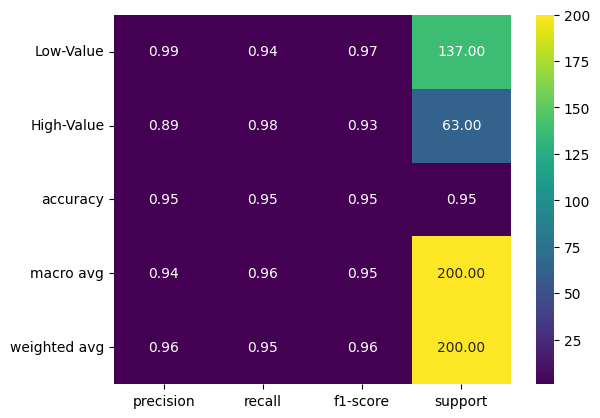

In [2]:
np.random.seed(427)

N = 1000
data = {
  'total_spending': np.random.lognormal(mean=6, sigma=1, size=N),
  'age': np.random.randint(18, 80, N),
  'num_visits': np.random.randint(1, 50, N),
  'purchase_frequency': np.random.uniform(0.5, 10, N),
  'is_high_value': np.zeros(N, dtype=int)
}

for i in range(N):
  score = (
    data['total_spending'][i] * 0.0005 +
    data['num_visits'][i] * 0.1 +
    data['purchase_frequency'][i] * 0.2
  )
  data['is_high_value'][i] = 1 if score > np.percentile([(
    data['total_spending'][j] * 0.0005 +
    data['num_visits'][j] * 0.1 +
    data['purchase_frequency'][j] * 0.2
  ) for j in range(N)], 70) else 0

df = pd.DataFrame(data)

df.loc[np.random.choice(df.index, 50), 'total_spending'] = np.nan
df.loc[np.random.choice(df.index, 30), 'purchase_frequency'] = np.nan

df['total_spending'] = df['total_spending'].fillna(df['total_spending'].median())
df['purchase_frequency'] = df['purchase_frequency'].fillna(df['purchase_frequency'].median())

def cap_outliers(series):
  Q1 = series.quantile(0.25)
  Q3 = series.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return series.clip(lower=lower_bound, upper=upper_bound)

for col in ['total_spending', 'num_visits', 'purchase_frequency']:
  df[col] = cap_outliers(df[col])

print("Class Distribution:")
print(df['is_high_value'].value_counts(normalize=True))

features = ['total_spending', 'age', 'num_visits', 'purchase_frequency']
X = df[features]
y = df['is_high_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

classification = classification_report(y_test, model.predict(X_test_scaled), target_names=['Low-Value', 'High-Value'], output_dict=True)
sns.heatmap(pd.DataFrame(classification).T, cmap='viridis', annot=True, fmt='.2f')

new_customer = pd.DataFrame({
  'total_spending': [1000],
  'age': [35],
  'num_visits': [20],
  'purchase_frequency': [5]
})
new_customer_scaled = scaler.transform(new_customer)
prediction = model.predict(new_customer_scaled)
print(f"Prediction: {'High-Value' if prediction[0] == 1 else 'Low-Value'}")